
# Online Retail EDA — What Drives Repeat Purchases?

**Goal**: Explore which types of products drive repeat purchases using the *Online Retail* dataset (Kaggle/UCI).  
**Stakeholder**: E‑commerce marketing & merchandising.  
**Decisions**: Promotions, bundling, and loyalty programs targeting repeat drivers.

> Before running, download `OnlineRetail.csv` from Kaggle and place it in this notebook's folder.


In [1]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
print("Versions → pandas:", pd.__version__)


Versions → pandas: 2.2.3


## 1) Load Data

In [5]:
# --- Load Online Retail CSV ---
DATA_PATH = "OnlineRetail.csv"

try:
    df = pd.read_csv(DATA_PATH, encoding="ISO-8859-1")
except FileNotFoundError as e:
    raise SystemExit(f"Could not find {DATA_PATH}. Place the file next to this notebook.") from e

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 2) Quick Data Check

In [7]:
print(df.shape)
print(df.columns.tolist())
df.info()
df.describe

(541909, 8)
['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


<bound method NDFrame.describe of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  Custo

## 3) Cleaning

In [8]:
# ---------- CLEANING ----------
# Keep a copy of raw for reference
raw = df.copy()

# Ensure text columns are strings
for col in ["InvoiceNo", "StockCode", "Description", "Country"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

# Drop obvious cancellations (invoices starting with 'C') BEFORE other filters
# (In this dataset, returns often appear as 'C' prefixed InvoiceNo and/or negative Quantity.)
if "InvoiceNo" in df.columns:
    df = df[~df["InvoiceNo"].str.startswith("C")]

# Drop rows without CustomerID (can't track repeat behavior)
df = df.dropna(subset=["CustomerID"])

# Cast CustomerID to integer where possible (helps grouping)
try:
    df["CustomerID"] = df["CustomerID"].astype(int)
except Exception:
    # If casting fails for a few rows, keep as float but it's fine for grouping
    pass

# Remove returns/cancellations (negative or zero Quantity)
df = df[df["Quantity"] > 0]

# Remove zero/negative prices
df = df[df["UnitPrice"] > 0]

# Optional: remove extreme outliers that are likely data errors
# (comment out if you prefer to keep everything)
df = df[(df["Quantity"] <= 2000) & (df["UnitPrice"] <= 5000)]

# Normalize product descriptions for grouping
if "Description" in df.columns:
    df["Description"] = df["Description"].str.lower()

# Parse dates and drop bad ones
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

# Add helpers: date-only and revenue
df["InvoiceDateDate"] = df["InvoiceDate"].dt.date
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Drop exact duplicate rows (common in this file)
df = df.drop_duplicates()

print("After cleaning:", df.shape)
df.head(3)

After cleaning: (392671, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateDate,Revenue
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,22.00



**Common pitfalls & how we handled them**
- Missing `CustomerID` → dropped.
- Negative `Quantity` (returns) → removed for repeat-buyer analysis.
- Bad dates → coerced with `to_datetime(..., errors="coerce")` and dropped nulls.
- Messy product names → lowercased & stripped whitespace.


## 4) Repeat Behavior Overview

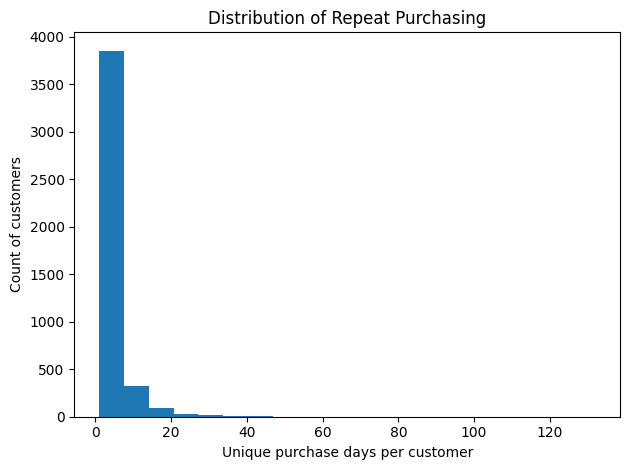

In [10]:

# Figure 1 — histogram of purchase days per customer
plt.figure()
cust_days.plot(kind="hist", bins=20)
plt.xlabel("Unique purchase days per customer")
plt.ylabel("Count of customers")
plt.title("Distribution of Repeat Purchasing")
plt.tight_layout()
plt.savefig("fig_repeat_hist.png", dpi=160)
plt.show()


## 5) Which Products Drive Repeat Purchases?

In [11]:
# Unique customers per product: a proxy for broad repeat appeal
prod_unique_customers = (df.groupby("Description")["CustomerID"]
                           .nunique()
                           .sort_values(ascending=False))

top_repeat = (prod_unique_customers.head(20)
                .reset_index()
                .rename(columns={"Description":"product",
                                 "CustomerID":"unique_customers"}))
top_repeat

,product,unique_customers
0,regency cakestand 3 tier,881
1,white hanging heart t-light holder,856
2,party bunting,708
3,assorted colour bird ornament,678
4,set of 3 cake tins pantry design,640
5,jumbo bag red retrospot,635
6,pack of 72 retrospot cake cases,635
7,paper chain kit 50's christmas,613
8,natural slate heart chalkboard,587
9,baking set 9 piece retrospot,581


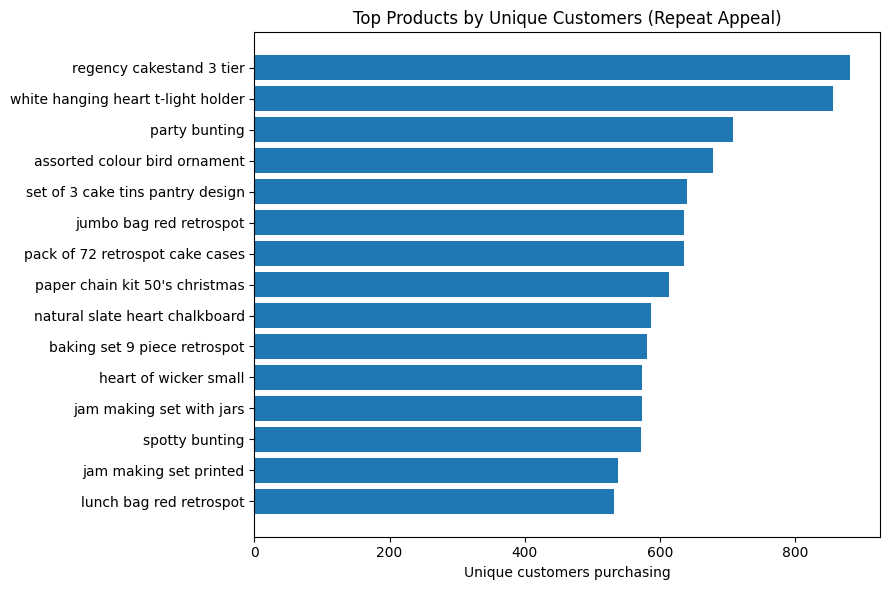

In [14]:
plt.figure(figsize=(9,6))
plt.barh(top_repeat["product"][::-1], top_repeat["unique_customers"][::-1])
plt.xlabel("Unique customers purchasing")
plt.title("Top Products by Unique Customers (Repeat Appeal)")
plt.tight_layout()
plt.savefig("fig_top_products.png", dpi=180)
plt.show()

## 6) Revenue Leaders (for context)

In [15]:
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

prod_revenue = (df.groupby("Description")["Revenue"]
                  .sum()
                  .sort_values(ascending=False))

top_revenue = (prod_revenue.head(20)
                 .reset_index()
                 .rename(columns={"Description":"product","Revenue":"revenue"}))
top_revenue


,product,revenue
0,regency cakestand 3 tier,142264.75
1,white hanging heart t-light holder,100392.10
2,jumbo bag red retrospot,85040.54
3,postage,69661.21
4,party bunting,68785.23
5,manual,53419.93
6,assorted colour bird ornament,52237.03
7,chilli lights,46265.11
8,rabbit night light,42607.64
9,paper chain kit 50's christmas,42584.13


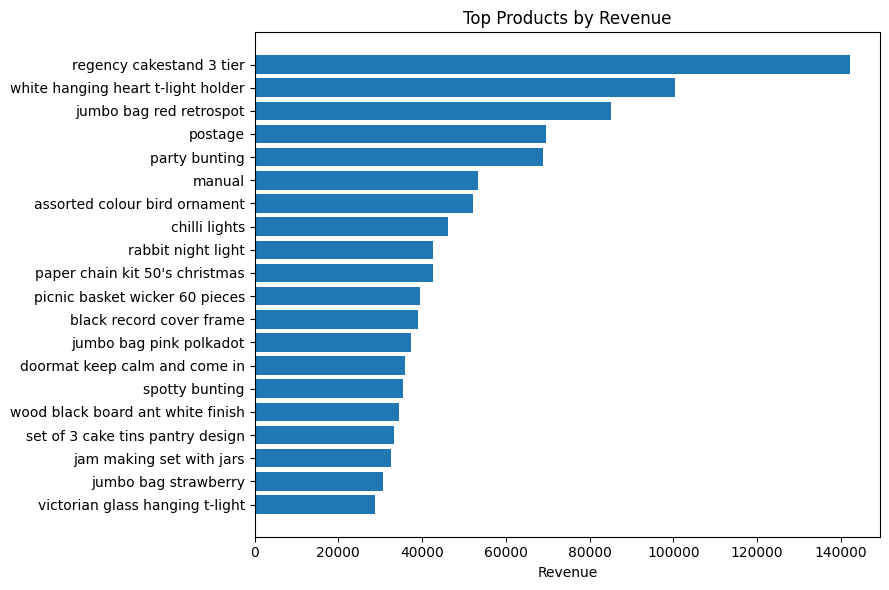

In [16]:
plt.figure(figsize=(9,6))
plt.barh(top_revenue["product"][::-1], top_revenue["revenue"][::-1])
plt.xlabel("Revenue")
plt.title("Top Products by Revenue")
plt.tight_layout()
plt.savefig("fig_top_revenue.png", dpi=180)
plt.show()

## 7) Repeat vs. Revenue (Join for a single summary table)

In [17]:
summary = (top_repeat.merge(top_revenue, on="product", how="outer")
                    .sort_values(["unique_customers","revenue"],
                                 ascending=[False, False]))
summary.head(15)

,product,unique_customers,revenue
20,regency cakestand 3 tier,881.0,142264.75
24,white hanging heart t-light holder,856.0,100392.10
16,party bunting,708.0,68785.23
0,assorted colour bird ornament,678.0,52237.03
21,set of 3 cake tins pantry design,640.0,33298.30
9,jumbo bag red retrospot,635.0,85040.54
14,pack of 72 retrospot cake cases,635.0,NaN
15,paper chain kit 50's christmas,613.0,42584.13
13,natural slate heart chalkboard,587.0,NaN
1,baking set 9 piece retrospot,581.0,NaN



## 8) Quick Validation / Reasonableness Checks
- Single retailer & time period → limited generalization.
- Missing `CustomerID` rows excluded → may undercount repeat behavior.
- Product categories not provided → analysis is at the item (description) level.
- Returns removed → good for repeat inference, but underestimates net revenue for return-prone items.

In [20]:
# No negative or zero quantities or prices
assert (df["Quantity"] > 0).all()
assert (df["UnitPrice"] > 0).all()

# Revenue should be non-negative
assert (df["Revenue"] >= 0).all()

# CustomerID present and integer-like after your cleaning
assert df["CustomerID"].notna().all()

# Dates parsed
assert df["InvoiceDate"].notna().all()

print("Basic validation passed ✅")

Basic validation passed ✅


## 9) Save Tables for Git/Medium

In [19]:
top_repeat.to_csv("table_top_repeat_products.csv", index=False)
top_revenue.to_csv("table_top_revenue_products.csv", index=False)
summary.to_csv("table_repeat_vs_revenue.csv", index=False)
print("Saved CSVs for tables.")


Saved CSVs for tables.
